In [1]:
import xgboost as xgb
import catboost
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# XGBoost D24

In [2]:
TEST_SIZE = 0.2
SEED = 0

In [3]:
df = pd.read_parquet("../data/data.parquet")

In [4]:
X = df.drop(["date", "D_12", "D_24", "D_36", "D_48", "D"], axis=1)
y = df["D_24"]

In [5]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=y
)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_temp,
    y_train_temp,
    test_size=TEST_SIZE,
    random_state=SEED,
    shuffle=True,
    stratify=y_train_temp,
)

In [7]:
model_path = "../models/xgboost_D24.pkl"

In [8]:
with open(model_path, "rb") as file:
    model: xgb.Booster = pickle.load(file)

In [9]:
# Get predicted probabilities from the XGBoost model
dtest = xgb.DMatrix(X_test)
y_test_probs = model.predict(dtest)

# Convert XGBoost model to a scikit-learn compatible classifier
xgb_sklearn = xgb.XGBClassifier()
xgb_sklearn._Booster = model

xgb_sklearn.fit(X_train, y_train)

# Calibrate probabilities using CalibratedClassifierCV
calibrated_xgb = CalibratedClassifierCV(xgb_sklearn, method="isotonic", cv="prefit")
calibrated_xgb.fit(X_valid, y_valid)

# Get calibrated probabilities
calibrated_probs = calibrated_xgb.predict_proba(X_test)[:, 1]

In [10]:
# Calculate Gini score before and after calibration
gini_before = 2 * roc_auc_score(y_test, y_test_probs) - 1
gini_after = 2 * roc_auc_score(y_test, calibrated_probs) - 1

print(f"Gini before calibration: {gini_before:.4f}")
print(f"Gini after calibration: {gini_after:.4f}")

Gini before calibration: 0.5092
Gini after calibration: 0.6516


In [11]:
# plt.figure(figsize=(16, 6))

# plt.subplot(1, 2, 1)
# plt.hist(y_test_probs, bins=10, color='blue', alpha=0.7)
# plt.title('Predictions Before Calibration')
# plt.xlabel('Predicted Probabilities')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(calibrated_probs, bins=10, color='orange', alpha=0.7)
# plt.title('Predictions After Calibration')
# plt.xlabel('Predicted Probabilities')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

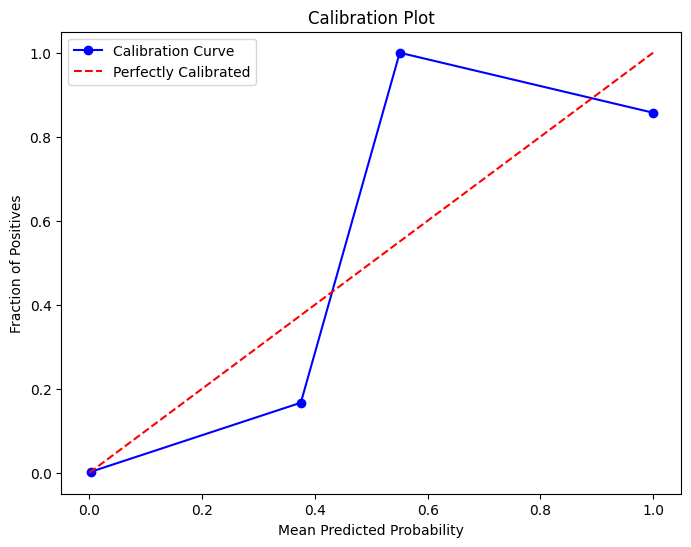

In [12]:
# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, calibrated_probs, n_bins=10
)

# Create a calibration plot
plt.figure(figsize=(8, 6))

plt.plot(
    mean_predicted_value,
    fraction_of_positives,
    marker="o",
    linestyle="-",
    color="blue",
    label="Calibration Curve",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Perfectly Calibrated")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot")
plt.legend()
plt.show()

In [13]:
model_pkl_file = "../models/xgboost_D24_calib.pkl"

with open(model_pkl_file, "wb") as file:
    pickle.dump(model, file)

# CatBoost D36

In [14]:
X = df.drop(["date", "D_12", "D_24", "D_36", "D_48", "D"], axis=1)
y = df["D_36"]

In [15]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=y
)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_temp,
    y_train_temp,
    test_size=TEST_SIZE,
    random_state=SEED,
    shuffle=True,
    stratify=y_train_temp,
)

In [17]:
model_path = "../models/catboost_D36.pkl"

In [18]:
import catboost


with open(model_path, "rb") as file:
    model: catboost.CatBoostClassifier = pickle.load(file)

In [19]:
# Get predicted probabilities before calibration
y_test_probs = model.predict_proba(X_test)[:, 1]

# Calibrate probabilities using sigmoid calibration
calibrated_catboost = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
calibrated_catboost.fit(X_test, y_test)  # Fit on the test set for calibration

# Get calibrated probabilities for the positive class
calibrated_probs = calibrated_catboost.predict_proba(X_test)[:, 1]

In [20]:
# Calculate Gini score before and after calibration
gini_before = 2 * roc_auc_score(y_test, y_test_probs) - 1
gini_after = 2 * roc_auc_score(y_test, calibrated_probs) - 1

print(f"Gini before calibration: {gini_before:.4f}")
print(f"Gini after calibration: {gini_after:.4f}")

Gini before calibration: 0.8376
Gini after calibration: 0.8533


In [21]:
# plt.figure(figsize=(16, 6))

# plt.subplot(1, 2, 1)
# plt.hist(y_test_probs, bins=10, color='blue', alpha=0.7)
# plt.title('Predictions Before Calibration')
# plt.xlabel('Predicted Probabilities')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(calibrated_probs, bins=10, color='orange', alpha=0.7)
# plt.title('Predictions After Calibration')
# plt.xlabel('Predicted Probabilities')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

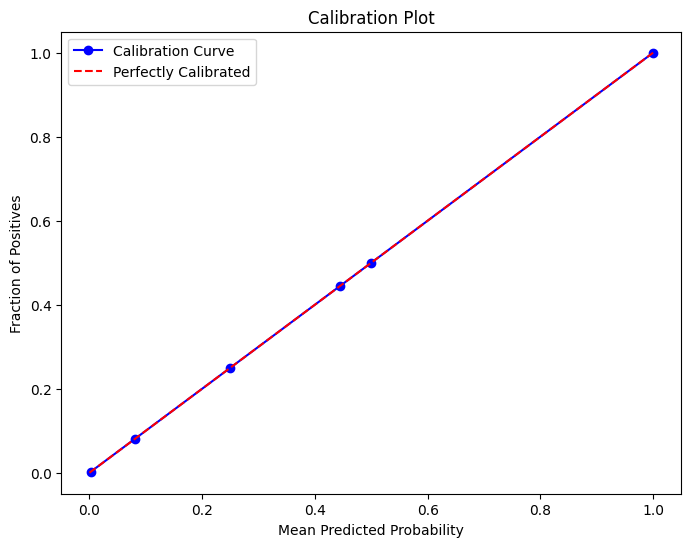

In [26]:
# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, calibrated_probs, n_bins=20
)

# Create a calibration plot
plt.figure(figsize=(8, 6))

plt.plot(
    mean_predicted_value,
    fraction_of_positives,
    marker="o",
    linestyle="-",
    color="blue",
    label="Calibration Curve",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Perfectly Calibrated")

plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot")
plt.legend()
plt.show()

In [23]:
model_pkl_file = "../models/catboost_D36_calib.pkl"

with open(model_pkl_file, "wb") as file:
    pickle.dump(model, file)